In [2]:
import sys
sys.path.append('beit2')
from datamodules import DATAMODULE_REGISTRY
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl

/Users/timcares/CompSci/Uni/Projects/MasterThesis/src/beit2/modeling_finetune.py:472: UserWarning: Overwriting beit_base_patch16_224 in registry with modeling_finetune.beit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/Users/timcares/CompSci/Uni/Projects/MasterThesis/src/beit2/modeling_finetune.py:493: UserWarning: Overwriting beit_base_patch16_384 in registry with modeling_finetune.beit_base_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/Users/timcares/CompSci/Uni/Projects/MasterThesis/src/beit2/modeling_finetune.py:509: UserWarning: Overwriting beit_large_patch16_224 in registry with modeling_finetune.beit_large_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/Users/timcares/CompSci/Uni/Proj

In [63]:
coco_dm_kwargs = {
    'data_path': '../data',
    'num_max_bpe_tokens': 64,
    'color_jitter': None,
    'beit_transforms': False,
    'crop_scale': [1.0, 1.0],
    'batch_size': 9*5,
    'num_workers': 1,
    'shuffle': True,
    'drop_last': False,
}

In [64]:
pl.seed_everything(42)
coco_dm = DATAMODULE_REGISTRY['coco_captions'](**coco_dm_kwargs)

Seed set to 42


In [65]:
coco_dm.prepare_data()
coco_dm.setup('test')

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../data/coco
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../data/coco
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /bert-base-uncased/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
INFO:datasets_.base_datasets:[COCOCaptions]: Data already exists under: ../data/coco
INFO:datasets_.base_datasets:[COCOCaptions]: Load 25010 image-text pairs from ../data/coco/coco_captioning.test.jsonl. 


In [66]:
dl = coco_dm.test_dataloader()

In [67]:
dl_iter = iter(dl)

/Users/timcares/CompSci/Uni/Projects/MasterThesis/src/beit2/modeling_finetune.py:472: UserWarning: Overwriting beit_base_patch16_224 in registry with modeling_finetune.beit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/Users/timcares/CompSci/Uni/Projects/MasterThesis/src/beit2/modeling_finetune.py:493: UserWarning: Overwriting beit_base_patch16_384 in registry with modeling_finetune.beit_base_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/Users/timcares/CompSci/Uni/Projects/MasterThesis/src/beit2/modeling_finetune.py:509: UserWarning: Overwriting beit_large_patch16_224 in registry with modeling_finetune.beit_large_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/Users/timcares/CompSci/Uni/Proj

In [8]:
def patchify(imgs):
    """
    imgs: (N, 3, H, W)
    x: (N, L, patch_size**2 *3)
    """
    p = 16
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
    return x

def unpatchify(x):
    """
    x: (N, L, patch_size**2 *3)
    imgs: (N, 3, H, W)
    """
    p = 16
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
    return imgs

In [9]:
def random_masking(x, mask_ratio):
    """
    Perform per-sample random masking by per-sample shuffling.
    Per-sample shuffling is done by argsort random noise.
    x: [N, L, D], sequence
    """
    N, L, _ = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))
    
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
    
    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=1)

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, L], device=x.device)
    mask[:, :len_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return mask

In [20]:
def mask_images(images, mask):
    p = 16  # Patch size
    N, _, H, W = images.shape
    h = w = H // p  # Number of patches along height and width

    # Reshape images to extract patches
    x = images.reshape(N, 3, h, p, w, p)
    x = torch.einsum('nchpwq->nhwpqc', x)  # Shape: (N, h, w, p, p, 3)

    # Reshape mask to align with patches
    mask_reshaped = mask.reshape(N, h, w)  # Shape: (N, h, w)

    # Expand dimensions for broadcasting
    mask_expanded = mask_reshaped[:, :, :, None, None, None]  # Shape: (N, h, w, 1, 1, 1)
    grey_patch = torch.full((p, p, 3), 0.75, device=images.device)  # Light grey color
    grey_patch_expanded = grey_patch[None, None, None, :, :, :]  # Shape: (1, 1, 1, p, p, 3)

    # Replace masked patches with grey color
    x = x * (1 - mask_expanded) + grey_patch_expanded * mask_expanded

    # Reshape to prepare for unpatchifying
    x_patches = x.reshape(N, h * w, p * p * 3)

    # Unpatchify to reconstruct images
    imgs_modified = unpatchify(x_patches)  # Shape: (N, 3, H, W)

    return imgs_modified

In [23]:
def plot_masked_image(image, masked_image):
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 2, wspace=0, hspace=0.5)
    ax = fig.add_subplot(gs[0, 0])

    ax.imshow(image.permute(1, 2, 0))
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1)

    ax = fig.add_subplot(gs[0, 1])
    
    ax.imshow(masked_image.permute(1, 2, 0))

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1)

    fig.show()

In [89]:
images = next(dl_iter)['image_raw']

/var/folders/gt/cjpcl37j15s8yxsjswrtpxf40000gn/T/ipykernel_73404/2808672290.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


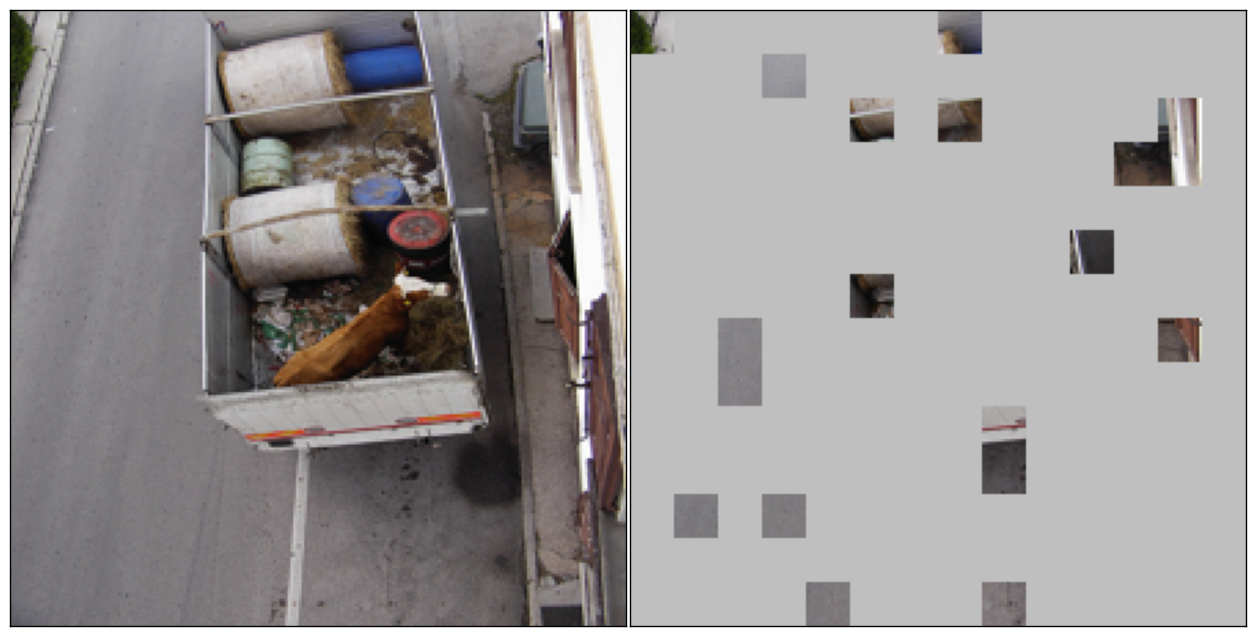

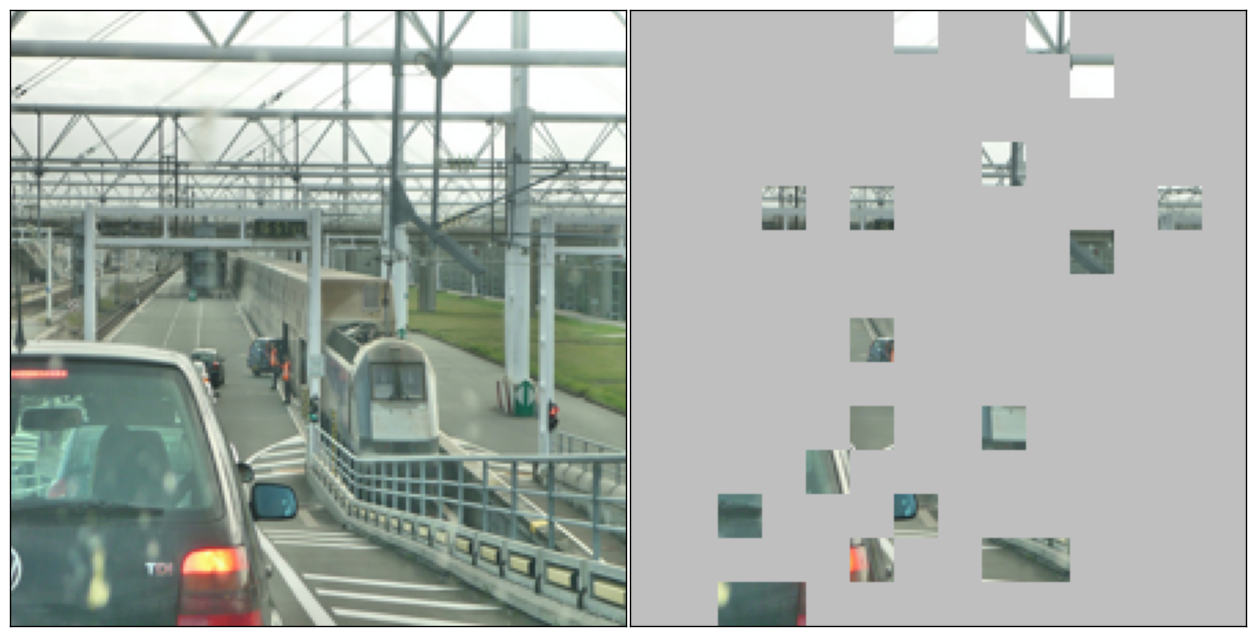

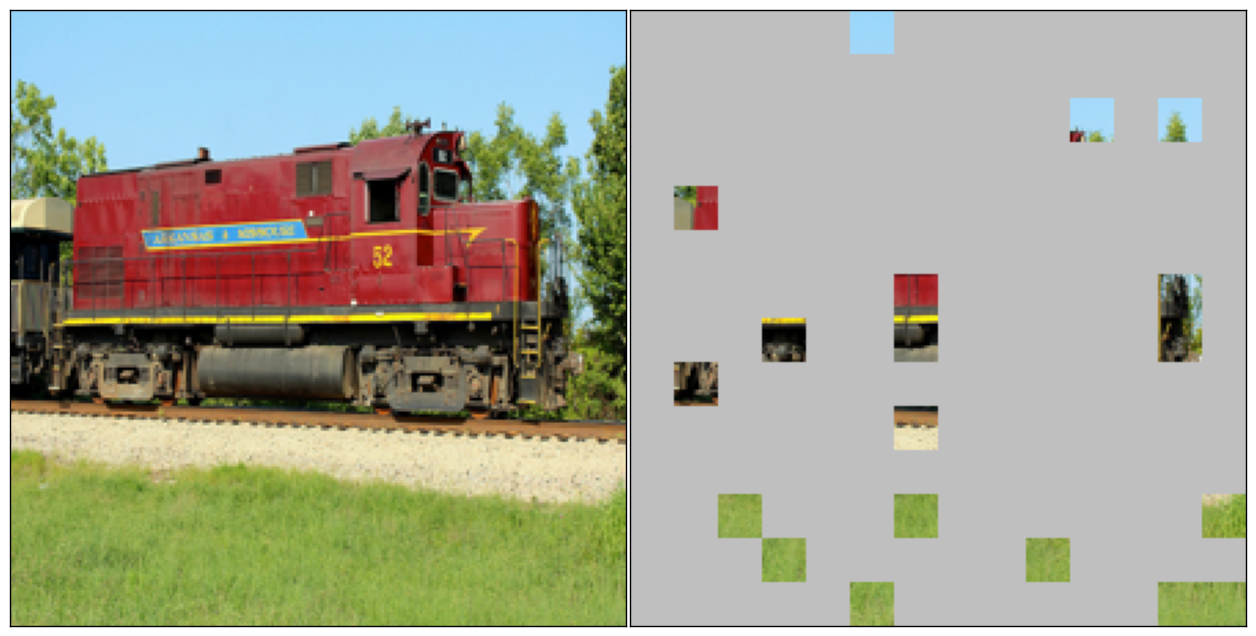

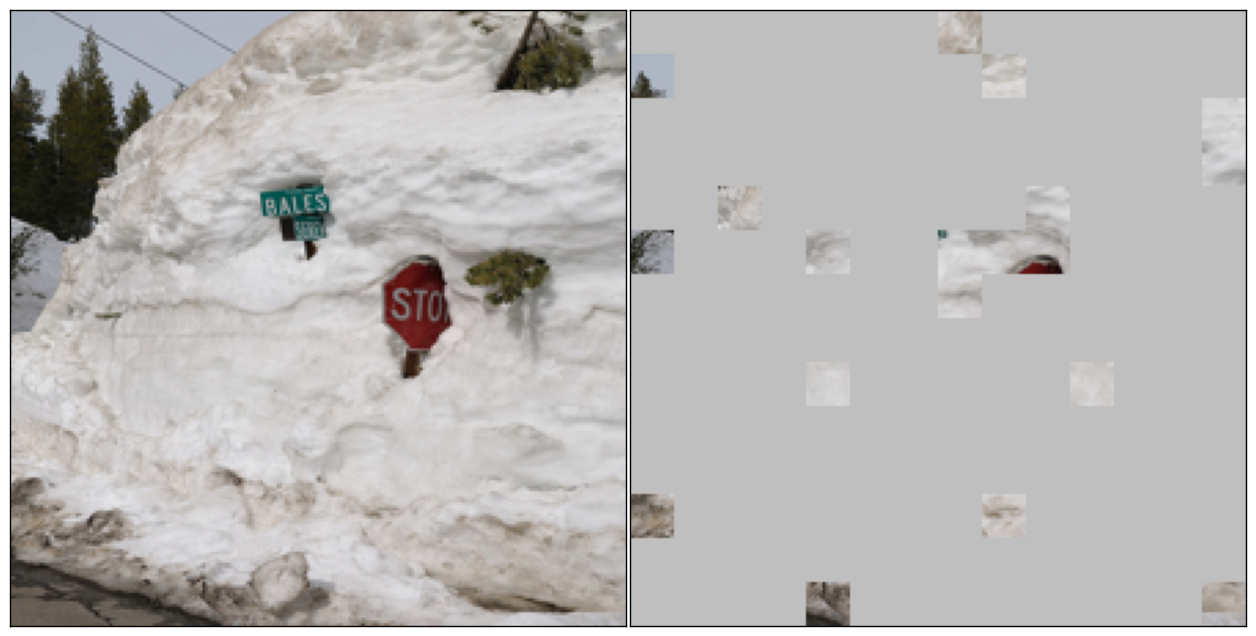

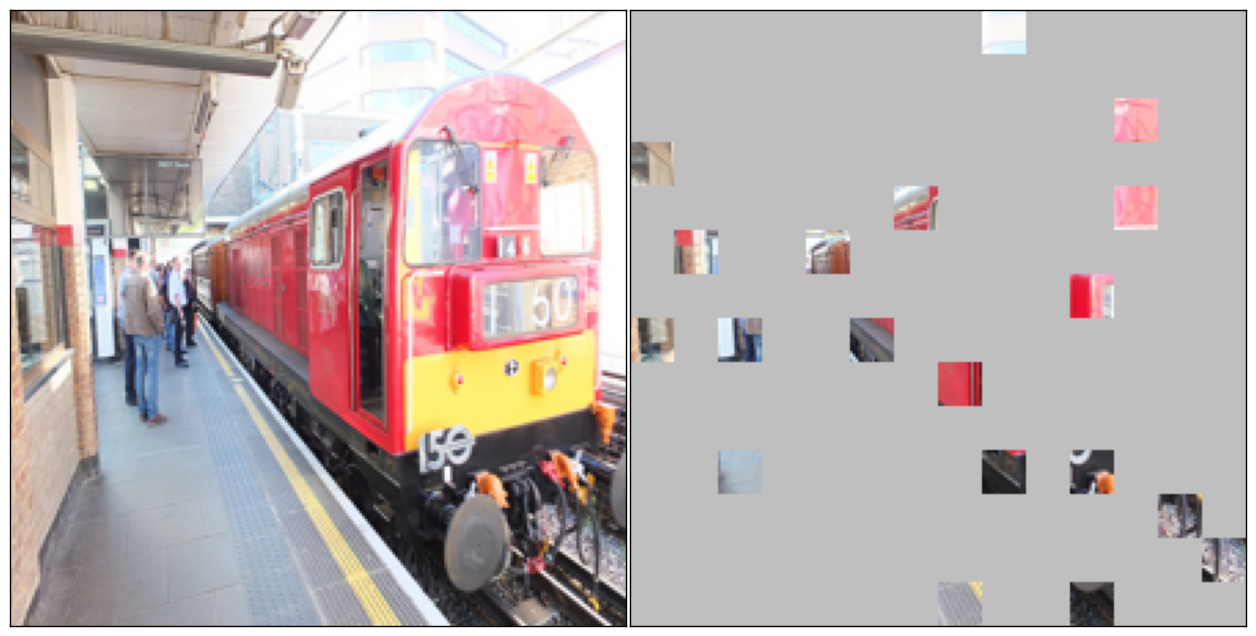

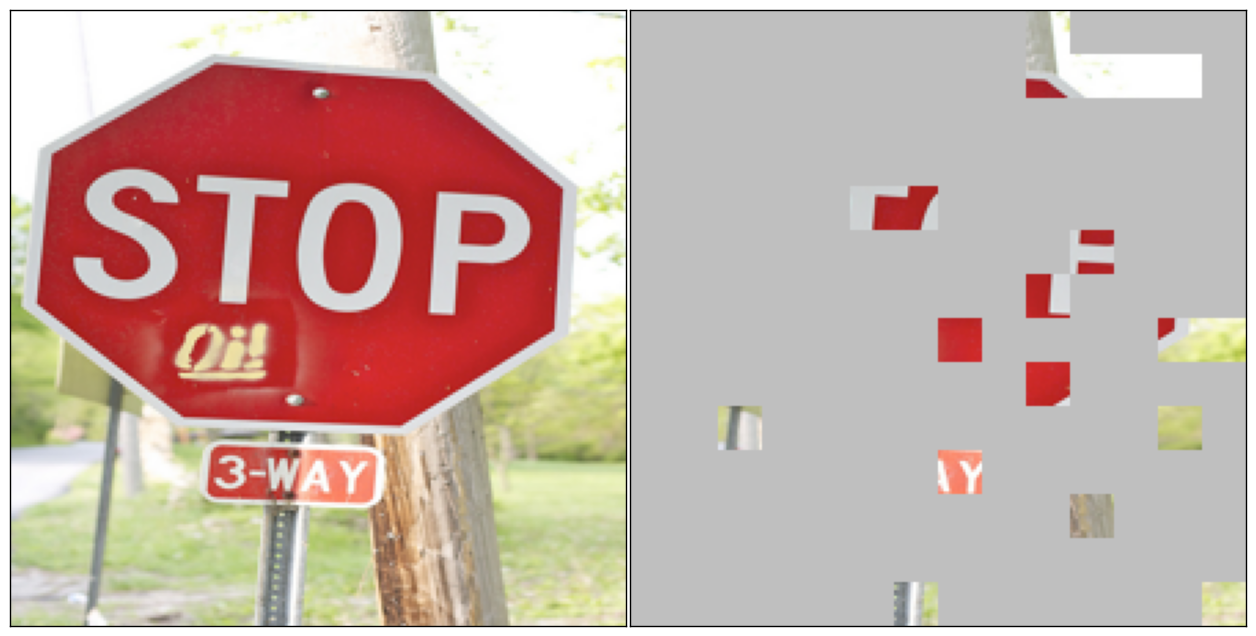

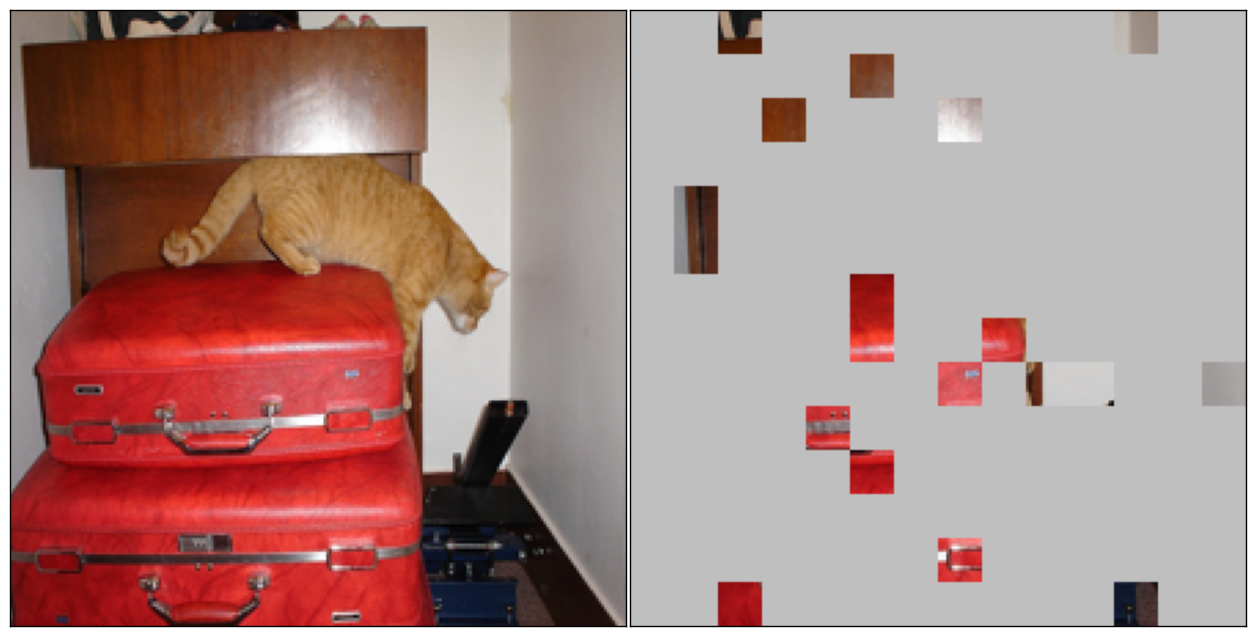

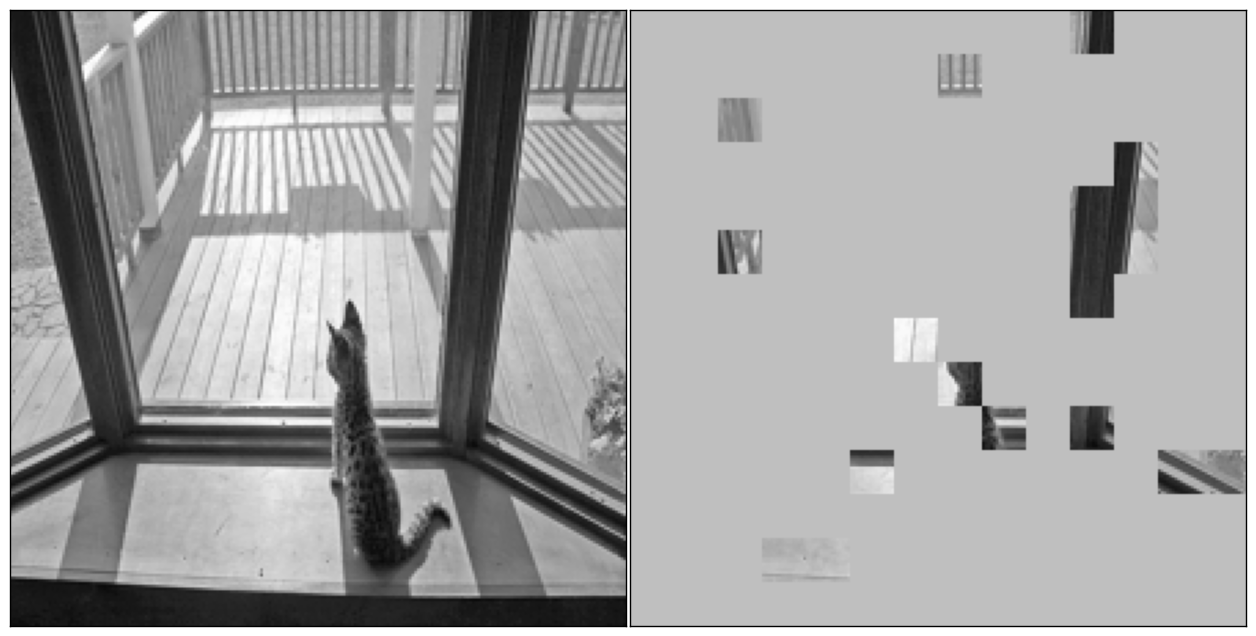

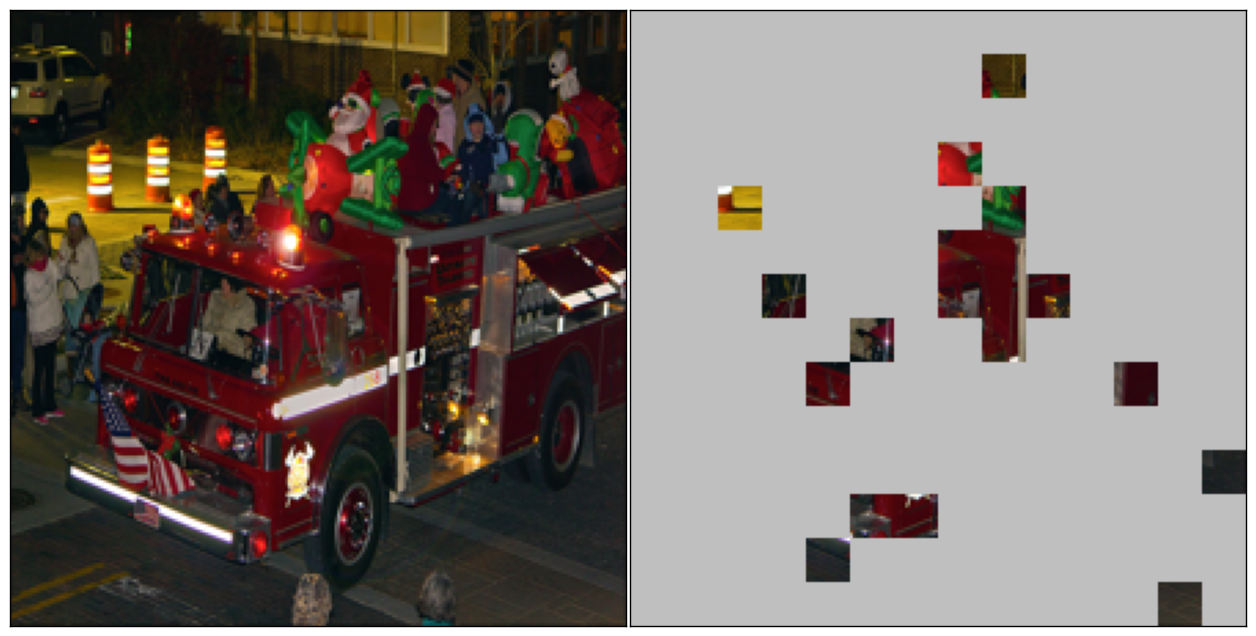

In [90]:
mask = random_masking(patchify(images), 0.9)
masked_images = mask_images(images, mask)
for i in range(0, masked_images.shape[0], 5):
    plot_masked_image(images[i], masked_images[i])